In [ ]:
import os
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
import gym
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class ActorCriticNetwork(keras.Model):
  def __init__(self, n_actions, fc1_dims=1024, fc2_dims=512, name='actor_critic', chkpt_dir = '/content/tmp'):
    super(ActorCriticNetwork, self).__init__()
    self.fc1_dims = fc1_dims
    self.fc2_dims = fc2_dims
    self.n_actions = n_actions
    self.model_name = name
    self.checkpoint_dir = chkpt_dir
    self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ac')

    self.fc1 = Dense(self.fc1_dims, activation='relu')
    self.fc2 = Dense(self.fc2_dims, activation='relu')
    self.v = Dense(1, activation = None)
    self.pi = Dense(n_actions, activation = 'softmax')

  def call(self, state):
    value = self.fc1(state)
    value = self.fc2(value)

    v = self.v(value)
    pi = self.pi(value)

    return v, pi

In [ ]:
class Agent:
  def __init__(self, alpha=0.0003, gamma=0.99, n_actions=2):
    # super(ActorCriticNetwork, self).__init__(type(n_actions))
    self.gamma = gamma
    self.n_actions = n_actions
    self.action = None
    self.action_space = [i for i in range(self.n_actions)]

    self.actor_critic = ActorCriticNetwork(n_actions=n_actions)

    self.actor_critic.compile(optimizer=Adam(learning_rate=alpha))

  def choose_action(self, observation):
    state = tf.convert_to_tensor([observation])
    _, probs = self.actor_critic(state)

    action_probabilities = tfp.distributions.Categorical(probs=probs)
    action = action_probabilities.sample()
    self.action = action

    return action.numpy()[0]

  def save_model(self):
    print('....saving model.....')
    self.actor_critic.save_weights(self.actor_critic.checkpoint_file)

  def load_model(self):
    print('.....loading models.....')
    self.actor_critic.load_weights(self.actor_critic.checkpoint_file)

  def learn(self, state, reward, state_, done):
    state = tf.convert_to_tensor([state], dtype=tf.float32)
    state_ = tf.convert_to_tensor([state_], dtype=tf.float32)
    reward = tf.convert_to_tensor(reward, dtype=tf.float32)

    with tf.GradientTape() as tape:
      state_value, probs = self.actor_critic(state)
      state_value_, _ = self.actor_critic(state_)
      state_value = tf.squeeze(state_value)
      state_value_ = tf.squeeze(state_value_)

      action_probs = tfp.distributions.Categorical(probs=probs)
      log_probs = action_probs.log_prob(self.action)

      delta = reward + self.gamma*state_value_*(1-int(done)) - state_value
      actor_loss = log_probs*delta
      critic_loss = delta**2

      total_loss = actor_loss + critic_loss

    gradient = tape.gradient(total_loss, self.actor_critic.trainable_variables)
    self.actor_critic.optimizer.apply_gradients(zip(gradient, self.actor_critic.trainable_variables))

....saving model.....
episode  0 score 18.0 avg_score 18.0
episode  1 score 18.0 avg_score 18.0
episode  2 score 9.0 avg_score 15.0
....saving model.....
episode  3 score 34.0 avg_score 19.8
episode  4 score 15.0 avg_score 18.8
....saving model.....
episode  5 score 25.0 avg_score 19.8
....saving model.....
episode  6 score 32.0 avg_score 21.6
episode  7 score 17.0 avg_score 21.0
episode  8 score 17.0 avg_score 20.6
episode  9 score 21.0 avg_score 20.6
episode  10 score 26.0 avg_score 21.1
episode  11 score 15.0 avg_score 20.6
episode  12 score 15.0 avg_score 20.2
episode  13 score 19.0 avg_score 20.1
episode  14 score 16.0 avg_score 19.8
episode  15 score 15.0 avg_score 19.5
episode  16 score 10.0 avg_score 18.9
episode  17 score 13.0 avg_score 18.6
episode  18 score 18.0 avg_score 18.6
episode  19 score 29.0 avg_score 19.1
episode  20 score 14.0 avg_score 18.9
episode  21 score 20.0 avg_score 18.9
episode  22 score 17.0 avg_score 18.8
episode  23 score 30.0 avg_score 19.3
episode  24

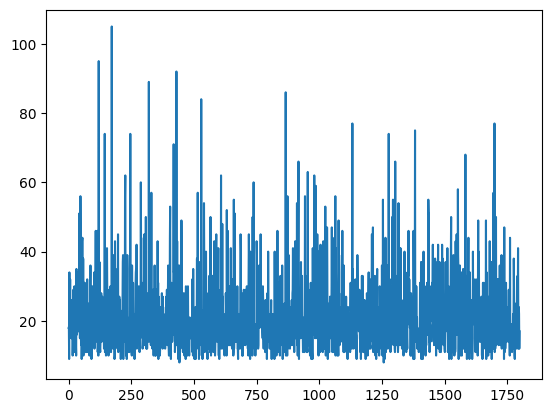

In [ ]:
if __name__ == '__main__':
  env = gym.make('CartPole-v1')
  agent = Agent(alpha=1e-7, n_actions = env.action_space.n)
  n_games=1800

  filename = 'cartpole.png'

  best_score = env.reward_range[0]
  score_history = []
  load_checkpoint = False

  if load_checkpoint:
    agent.load_model()

  for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
      action = agent.choose_action(observation)
      observation_, reward, done, info = env.step(action)
      score += reward
      if not load_checkpoint:
        agent.learn(observation, reward, observation_, done)
      observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
      best_score = avg_score
      if not load_checkpoint:
        agent.save_model()

    print('episode ', i, 'score %.1f' % score, 'avg_score %.1f' %avg_score)

  x = [i for i in range(n_games)]
  plt.plot(x, score_history)